#**Машинное обучение ИБ-2024**

#**Домашнее задание 3.**
#Классификация текстов, методы обучения без учителя.

**Все выводы ячеек вашей сданной работы должны оставаться в сданном ноутбуке, результаты должны быть видны. В противном случае 0 за задание!**

## Классификация текстов.

В этой части домашней работы Вам требуется реализовать полный пайплайн работы с текстами и моделями машинного обучения. От предобработки до запуска обучения моделей для задачи классификации.

**Задачи**:
1. Предобработка - Вам необходимо в представленных текстах избавиться от пунктуации, чисел и стоп-слов (nltk stopwords), привести тексты к нижнему регистру.
2. Сделать на Вашем корпусе очищенных текстов Лемматизацию или Стемминг. При этом словестно пояснить, что делает метод.
3. Разбить полученный датасет на train и test выборки в отношении 4:1
4. Привести ваши тексты из датасета к векторному формату. Тут необходимо попробовать два метода, разобранных на семинаре: Bag of words и TF-IDF. При этом словестно пояснить, что делает метод.
5. Провести кросс-валидация на подбор гиперпараметров моделей (GridSearchCV) и обучить модели: Логистическая регрессия, Random Forest, Gradient Boosting из CatBoost или XGBoost или LightGBM. (В данном задании не стоит "упарываться" в подбор гиперпараметров и считать каждую модель по 10 часов, покажите в коде, что Вы перебирали по сетке 2-3 гиперпараметра в разумном по времени интервале).
6. Замерьте метрики accuracy, precision, recall, F1-Score, ROC-AUC. Постройте ConfusionMatrix, сделайте анализ решения.

Все пункты задания весят по 1 Баллу. То есть за данный раздел можно получить максимум 6 Баллов.

In [2]:
import numpy as np
import pandas as pd
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\я\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\я\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Загружаю необходимые библиотеки и скачиваю ресурсы для предобработки текста.

In [5]:
file_path = 'combined_data.csv'
data = pd.read_csv(file_path)

# Отбор 25,000 случайных строк
random_data = data.sample(n=25000, random_state=42)
random_data.head()


,label,text
67681,0,accuweather escapenumber day forecast for beve...
61385,1,dear in christ the time has come for christian...
41829,1,hallway cosponsor pry reimbursable coat clumsy...
29172,1,does size matter' escapenumber of women said t...
35274,0,along zeng wrote hi all is there levene' test ...


1. Предобработка текста

В этом шаге я провожу предобработку текста. Удаляю все ненужное: пунктуацию, числа и стоп-слова из NLTK. Привожу текст к нижнему регистру и очищаю его от лишних символов и пробелов с помощью регулярных выражений. После этого разбиваю текст на отдельные слова (токенизация), что делает его удобным для дальнейшего анализа. Эти этапы важны, чтобы подготовить данные к обучению моделей.

In [7]:
# Задание 1: Предобработка текста
# Функция предобработки текста
def clean_text(text):
    # Приведение текста к нижнему регистру
    text = text.lower()
    # Удаление пунктуации и чисел
    text = text.translate(str.maketrans('', '', string.punctuation + string.digits))
    # Удаление лишних пробелов
    text = re.sub(r'\s+', ' ', text).strip()
    # Токенизация текста
    tokens = word_tokenize(text)
    # Удаление стоп-слов
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Применение предобработки к данным
random_data['cleaned_text'] = random_data['text'].apply(clean_text)
random_data[['text', 'cleaned_text']].head()


,text,cleaned_text
67681,accuweather escapenumber day forecast for beve...,accuweather escapenumber day forecast beverly ...
61385,dear in christ the time has come for christian...,dear christ time come christians worship god s...
41829,hallway cosponsor pry reimbursable coat clumsy...,hallway cosponsor pry reimbursable coat clumsy...
29172,does size matter' escapenumber of women said t...,size matter escapenumber women said thay unhap...
35274,along zeng wrote hi all is there levene' test ...,along zeng wrote hi levene test r could give a...


2. Лемматизация текста

Здесь я провожу лемматизацию текста с помощью WordNetLemmatizer из библиотеки NLTK. Лемматизация помогает привести слова к их базовой форме, учитывая контекст. Например, слово "running" преобразуется в "run". Это снижает количество уникальных слов в корпусе и упрощает анализ данных. Я предпочитаю лемматизацию, так как она точнее, чем стемминг, который иногда обрезает слова некорректно.

In [9]:
# Задание 2: Лемматизация текста
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    tokens = text.split()
    return ' '.join([lemmatizer.lemmatize(token) for token in tokens])

random_data['lemmatized_text'] = random_data['cleaned_text'].apply(lemmatize_text)

# Задание 3: Разделение данных на обучающую и тестовую выборки (80% / 20%)
X = random_data['lemmatized_text']
y = random_data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Вывод размеров выборок
print(f"Размер обучающей выборки: {len(X_train)}")
print(f"Размер тестовой выборки: {len(X_test)}")
random_data[['cleaned_text', 'lemmatized_text']].head()


Размер обучающей выборки: 20000
Размер тестовой выборки: 5000


,cleaned_text,lemmatized_text
67681,accuweather escapenumber day forecast beverly ...,accuweather escapenumber day forecast beverly ...
61385,dear christ time come christians worship god s...,dear christ time come christian worship god sp...
41829,hallway cosponsor pry reimbursable coat clumsy...,hallway cosponsor pry reimbursable coat clumsy...
29172,size matter escapenumber women said thay unhap...,size matter escapenumber woman said thay unhap...
35274,along zeng wrote hi levene test r could give a...,along zeng wrote hi levene test r could give a...


3. Разделение на train и test выборки

На этом этапе я делю данные на две выборки: обучающую и тестовую, в соотношении 80% на обучение и 20% на тест. Для этого я использую метод train_test_split из библиотеки sklearn. Такое разделение позволяет мне обучить модель на одной части данных, а затем проверить её способность обобщать на новых, ранее не виденных примерах. Это помогает избежать переобучения.

In [37]:
X = random_data['lemmatized_text']
y = random_data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Вывод размеров выборок
print(f"Размер обучающей выборки: {len(X_train)}")
print(f"Размер тестовой выборки: {len(X_test)}")

Размер обучающей выборки: 20000
Размер тестовой выборки: 5000


4. Векторизация текста

Теперь я преобразую текстовые данные в числовой формат, чтобы алгоритмы машинного обучения могли их обработать. Использую два метода:

- Bag of Words (CountVectorizer): Представляю текст как матрицу частот слов. Этот метод прост и хорошо подходит для начального анализа.

- TF-IDF (TfidfVectorizer): Учитываю важность слов в документе относительно всего корпуса, что позволяет снизить вес часто встречающихся слов. Этот метод даёт более качественное представление текста.


In [10]:
# Задание 4: Векторизация текста
# 1. Bag of Words (CountVectorizer)
bow_vectorizer = CountVectorizer(max_features=5000)
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

# 2. TF-IDF (TfidfVectorizer)
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(X_train_bow.shape, X_train_tfidf.shape)



(20000, 5000) (20000, 5000)


5. Обучение моделей и подбор гиперпараметров

На этом этапе я обучаю три модели для классификации текста:

- Логистическая регрессия: Простая, но эффективная модель для задач бинарной классификации.
- Random Forest: Использую случайный лес, так как он хорошо справляется с задачами классификации благодаря ансамблевому подходу.
- XGBoost: Мощный алгоритм градиентного бустинга, который особенно хорош для обработки табличных данных.

Для каждой модели я провожу подбор гиперпараметров с помощью GridSearchCV, чтобы найти лучшие параметры. Я ограничиваю перебор до двух-трёх гиперпараметров, чтобы процесс обучения не занимал слишком много времени.

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Логистическая регрессия
log_reg = LogisticRegression(max_iter=1000)
log_reg_params = {'C': [0.1, 1, 10]}  # Перебор гиперпараметра C
log_reg_search = GridSearchCV(log_reg, log_reg_params, cv=5, n_jobs=-1)
log_reg_search.fit(X_train_tfidf, y_train)
best_log_reg_model = log_reg_search.best_estimator_
log_reg_accuracy = best_log_reg_model.score(X_test_tfidf, y_test)

# Случайный лес
rf_clf = RandomForestClassifier(random_state=42)
rf_params = {'n_estimators': [50, 100], 'max_depth': [5, 10]}  # Перебор гиперпараметров
rf_search = GridSearchCV(rf_clf, rf_params, cv=5, n_jobs=-1)
rf_search.fit(X_train_tfidf, y_train)
best_rf_model = rf_search.best_estimator_
rf_accuracy = best_rf_model.score(X_test_tfidf, y_test)

# XGBoost
xgb_clf = XGBClassifier(eval_metric='logloss')
xgb_params = {'learning_rate': [0.01, 0.1], 'n_estimators': [50, 100]}  # Перебор гиперпараметров
xgb_search = GridSearchCV(xgb_clf, xgb_params, cv=5, n_jobs=-1)
xgb_search.fit(X_train_tfidf, y_train)
best_xgb_model = xgb_search.best_estimator_
xgb_accuracy = best_xgb_model.score(X_test_tfidf, y_test)

# Результаты
log_reg_accuracy, rf_accuracy, xgb_accuracy



(0.9824, 0.891, 0.9588)

6. Оценка моделей и визуализация результатов

После обучения моделей я оцениваю их качество с помощью следующих метрик:

- Accuracy: Доля правильно классифицированных объектов.
- Precision и Recall: Оцениваю точность и полноту классификации. Precision показывает, сколько из предсказанных положительных примеров действительно являются таковыми, а Recall отражает, сколько из всех реальных положительных примеров модель смогла правильно предсказать.
- F1-Score: Гармоническое среднее между Precision и Recall, чтобы сбалансировать эти показатели.
- ROC-AUC: Эта метрика оценивает качество модели для различных порогов классификации. Чем выше её значение, тем лучше модель.

Дополнительно я строю Confusion Matrix (матрицу ошибок), чтобы наглядно увидеть, как часто модель ошибается, и определить количество верных и неверных классификаций для каждой категории. Это помогает мне лучше понять, как модель работает с данными.

Accuracy XGBoost: 0.9588
Classification Report for XGBoost:
               precision    recall  f1-score   support

           0       0.98      0.93      0.96      2369
           1       0.94      0.99      0.96      2631

    accuracy                           0.96      5000
   macro avg       0.96      0.96      0.96      5000
weighted avg       0.96      0.96      0.96      5000

ROC-AUC Score for XGBoost: 0.9573414298042996


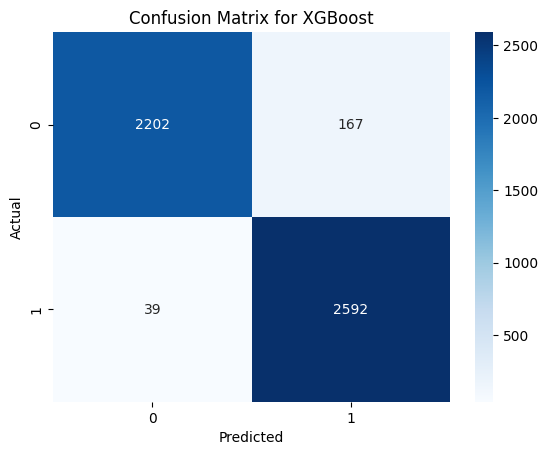

In [12]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# Предсказания для лучшей модели (например, XGBoost)
y_pred_xgb = best_xgb_model.predict(X_test_tfidf)

# Метрики для оценки
print("Accuracy XGBoost:", best_xgb_model.score(X_test_tfidf, y_test))
print("Classification Report for XGBoost:\n", classification_report(y_test, y_pred_xgb))
print("ROC-AUC Score for XGBoost:", roc_auc_score(y_test, y_pred_xgb))

# Confusion Matrix для XGBoost
cm = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for XGBoost')
plt.show()


## Обучение без учителя

Сгенерируем смесь Гауссовских распределений. Эти данные Вам необходимо будет далее кластеризировать с помощью различных алгоритмов  кластеризации. Во всех заданиях Вам необходимо отрисовывать кластеры, которые Вы получили в результате работы моделей (графики, оси должны быть подписаны).

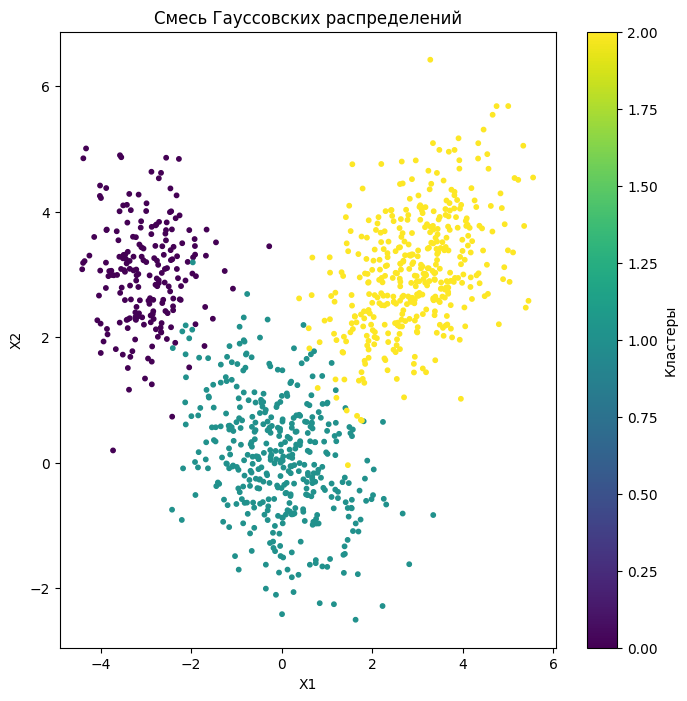

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Установим параметры
np.random.seed(42)
n_samples = 1000
centroids = [(-3, 3), (0, 0), (3, 3)]
cov_matrices = [np.array([[0.5, 0], [0, 0.75]]), 
                np.array([[1, -0.4], [-0.4, 1]]), 
                np.array([[1, 0.5], [0.5, 1]])]
cluster_weights = [0.2, 0.4, 0.4]

# Генерация выборки
X = np.vstack([
    np.random.multivariate_normal(centroids[i], cov_matrices[i], int(cluster_weights[i] * n_samples))
    for i in range(len(centroids))
])

true_labels = np.hstack([
    np.full(int(cluster_weights[i] * n_samples), i)
    for i in range(len(centroids))
])

# Визуализация данных
plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=true_labels, cmap='viridis', s=10)
plt.title("Смесь Гауссовских распределений")
plt.xlabel("X1")
plt.ylabel("X2")
plt.colorbar(label="Кластеры")
plt.show()


**Задание 1 [1 Балл].** Заиспользуйте метод K-Means для кластеризации полученной смесси Гауссовских распределений. Подберите гиперпараметр K максимизируя метрику индекс Силуэта (Silhouette Coefficient).

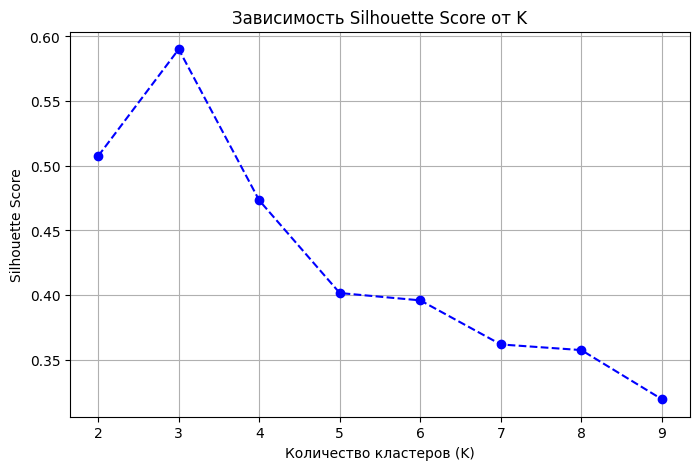

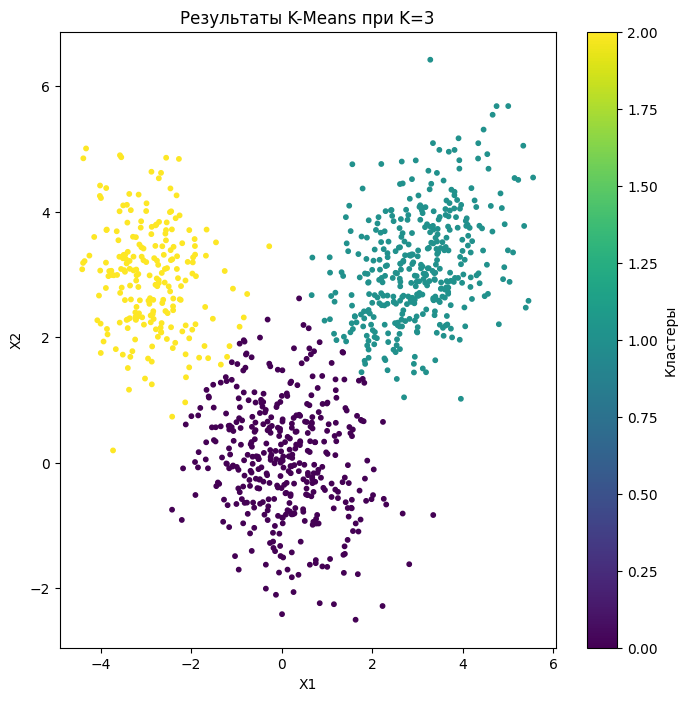

3

In [14]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Поиск оптимального K
silhouette_scores = []
k_candidates = range(2, 10)

for k in k_candidates:
    kmeans_model = KMeans(n_clusters=k, random_state=42, init='k-means++')
    kmeans_labels = kmeans_model.fit_predict(X)
    silhouette_scores.append(silhouette_score(X, kmeans_labels))

# Определяем оптимальное K
optimal_k = k_candidates[np.argmax(silhouette_scores)]

# График оценки качества
plt.figure(figsize=(8, 5))
plt.plot(k_candidates, silhouette_scores, 'o--', color='blue')
plt.title("Зависимость Silhouette Score от K")
plt.xlabel("Количество кластеров (K)")
plt.ylabel("Silhouette Score")
plt.grid()
plt.show()

# Визуализация кластеров
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, init='k-means++')
final_labels = final_kmeans.fit_predict(X)

plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=final_labels, cmap='viridis', s=10)
plt.title(f"Результаты K-Means при K={optimal_k}")
plt.xlabel("X1")
plt.ylabel("X2")
plt.colorbar(label="Кластеры")
plt.show()

optimal_k


**Задание 2 [1 Балл].** Заиспользуйте метод DBSCAN для кластеризации полученной смесси Гауссовских распределений. Подберите гиперпараметры eps, min_samples максимизируя метрику BCubed (золотой стандарт записан в переменной labels).

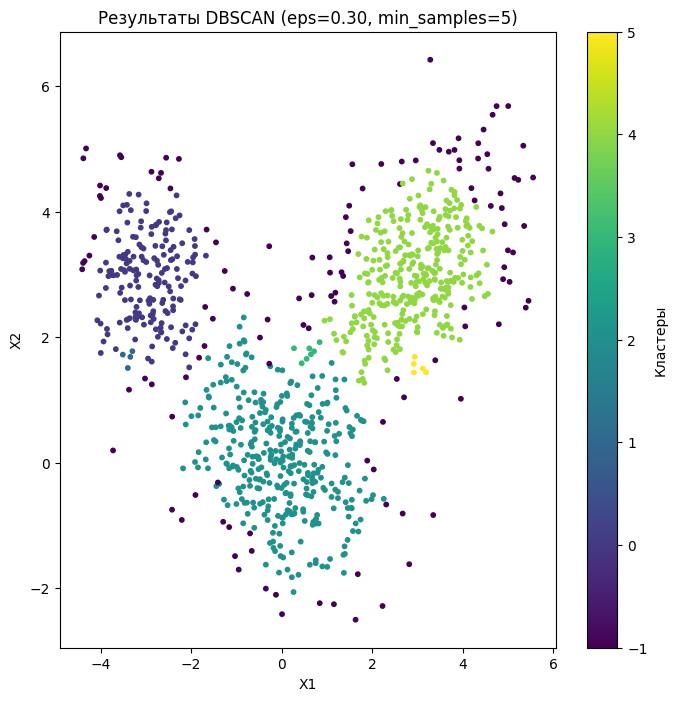

((np.float64(0.30000000000000004), 5), np.float64(0.8187567802465431))

In [15]:
from sklearn.cluster import DBSCAN
from itertools import combinations

# Функция для вычисления BCubed Precision, Recall и F1-Score
def bcubed_metrics(true_labels, predicted_labels):
    tp, fp, fn = 0, 0, 0
    for i, j in combinations(range(len(true_labels)), 2):
        same_true = true_labels[i] == true_labels[j]
        same_pred = predicted_labels[i] == predicted_labels[j]
        tp += same_true and same_pred
        fp += not same_true and same_pred
        fn += same_true and not same_pred

    precision = tp / (tp + fp) if tp + fp else 0
    recall = tp / (tp + fn) if tp + fn else 0
    f1 = 2 * precision * recall / (precision + recall) if precision + recall else 0
    return precision, recall, f1

# Подбор гиперпараметров eps и min_samples
eps_values = np.linspace(0.1, 1.0, 10)
min_samples_values = range(3, 10)

best_f1 = 0
best_params = None

for eps in eps_values:
    for min_samples in min_samples_values:
        model = DBSCAN(eps=eps, min_samples=min_samples)
        predicted_labels = model.fit_predict(X)
        
        # Исключение выбросов
        if len(set(predicted_labels)) > 1:
            precision, recall, f1 = bcubed_metrics(true_labels, predicted_labels)
            if f1 > best_f1:
                best_f1 = f1
                best_params = (eps, min_samples)

# Визуализация кластеров для лучших параметров
best_eps, best_min_samples = best_params
dbscan_model = DBSCAN(eps=best_eps, min_samples=best_min_samples)
dbscan_labels = dbscan_model.fit_predict(X)

plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=dbscan_labels, cmap='viridis', s=10)
plt.title(f"Результаты DBSCAN (eps={best_eps:.2f}, min_samples={best_min_samples})")
plt.xlabel("X1")
plt.ylabel("X2")
plt.colorbar(label="Кластеры")
plt.show()

best_params, best_f1


**Задание 3 [2 Балл].** Реализуйте EM алгоритм для кластеризации смеси Гауссовских смесей. Попробуйте его применить для кластеризации. Распишите, что делает E и M шаги в коде комментариями. Напишите краткий отчет, какой из алгоритмов кластеризации сработал лучше всего на сгенерированных данных.

EM алгоритм для разделения смеси Гауссовских распределений:

$$
p(X, Z|\pi, \mu, \Sigma) = \prod_{i=1}^\ell \prod_{k=1}^K \Big[\pi_k \mathcal{N}(x_i | \mu_k, \Sigma_k) \Big]^{z_ik}
$$

Соответственно, Е-шаг:

$$
g_{ik} := p\big(z_{ik} = 1\big|x_i, \pi, \mu, \Sigma\big) = \frac{\pi_k \mathcal{N}(x_i | \mu_k, \Sigma_k)}{\sum_{s=1}^K \pi_s \mathcal{N}(x_i | \mu_s, \Sigma_s)}
$$

И М-шаг:

$$
\pi_k = \frac{1}{\ell} \sum_{i=1}^\ell g_{ik} \quad\quad \mu_k = \frac{1}{\ell \pi_k} \sum_{i=1}^\ell g_{ik} x_i
$$

$$
\Sigma_k = \frac{1}{\ell \pi_k} \sum_{i=1}^\ell g_{ik} (x_i - \mu_k) (x_i - \mu_k)^T
$$

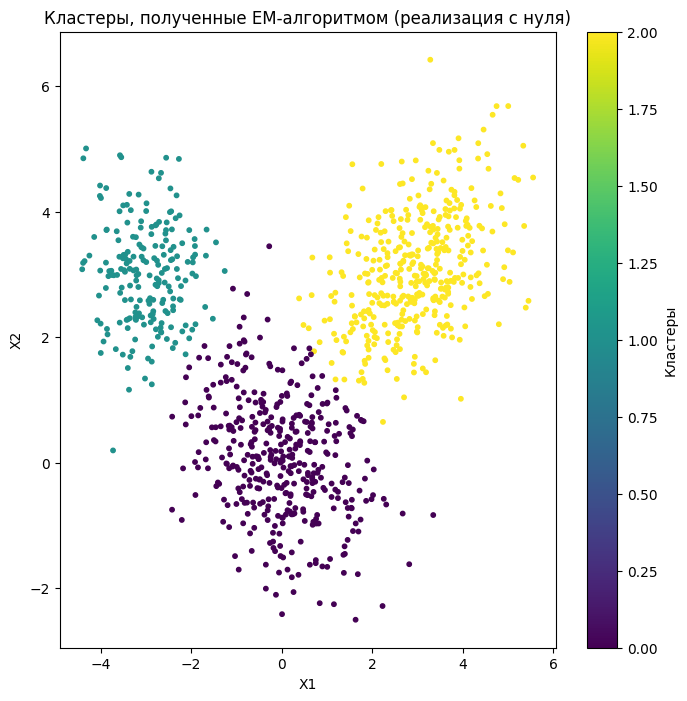

(array([0.39917833, 0.20165186, 0.39916982]),
 array([[-0.02326138,  0.06419867],
        [-2.96663932,  2.99560052],
        [ 2.93432824,  3.04645605]]),
 array([[[ 1.03305503, -0.29883072],
         [-0.29883072,  0.94118783]],
 
        [[ 0.43676802, -0.04870124],
         [-0.04870124,  0.67240355]],
 
        [[ 1.03153735,  0.4272672 ],
         [ 0.4272672 ,  0.87725871]]]))

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal


# Инициализация параметров
n_clusters = 3
max_iter = 100
tol = 1e-6

# Случайное начальное распределение весов
weights = np.ones(n_clusters) / n_clusters

# Случайный выбор начальных средних и ковариаций
means = X[np.random.choice(len(X), n_clusters, replace=False)]
covariances = np.array([np.cov(X.T) for _ in range(n_clusters)])

# Лог-функция правдоподобия
def log_likelihood(X, weights, means, covariances):
    likelihoods = np.zeros((X.shape[0], len(weights)))
    for k in range(len(weights)):
        likelihoods[:, k] = weights[k] * multivariate_normal.pdf(X, mean=means[k], cov=covariances[k])
    return np.sum(np.log(np.sum(likelihoods, axis=1)))

# Основной цикл EM-алгоритма
for iteration in range(max_iter):
    # E-шаг: вычисление принадлежности точек к кластерам
    responsibilities = np.zeros((X.shape[0], n_clusters))
    for k in range(n_clusters):
        responsibilities[:, k] = weights[k] * multivariate_normal.pdf(X, mean=means[k], cov=covariances[k])
    responsibilities /= responsibilities.sum(axis=1, keepdims=True)

    # M-шаг: обновление параметров кластеров
    n_k = responsibilities.sum(axis=0)
    weights = n_k / len(X)
    means = np.dot(responsibilities.T, X) / n_k[:, None]
    covariances = []
    for k in range(n_clusters):
        diff = X - means[k]
        covariances.append(np.dot((responsibilities[:, k, None] * diff).T, diff) / n_k[k])
    covariances = np.array(covariances)

    # Проверка сходимости по лог-функции правдоподобия
    new_log_likelihood = log_likelihood(X, weights, means, covariances)
    if iteration > 0 and abs(new_log_likelihood - prev_log_likelihood) < tol:
        break
    prev_log_likelihood = new_log_likelihood

# Предсказание кластеров
final_responsibilities = responsibilities.argmax(axis=1)

# Визуализация кластеров
plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=final_responsibilities, cmap='viridis', s=10)
plt.title("Кластеры, полученные EM-алгоритмом (реализация с нуля)")
plt.xlabel("X1")
plt.ylabel("X2")
plt.colorbar(label="Кластеры")
plt.show()

weights, means, covariances


**Бонус [1 Балл].** Заиспользуйте модель GaussianMixture для кластеризации сгенерированной выборки. Мы не проходили GaussianMixture, поэтому для бонусного балла ознакомьтесь с моделью и опишите, как она работает.

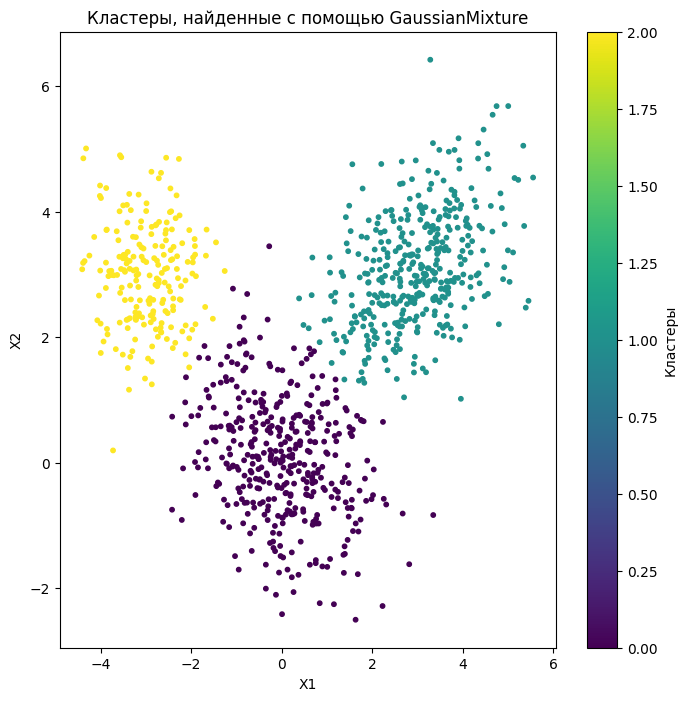

Веса кластеров (π_k): [0.39934254 0.39678151 0.20387595]
Центры кластеров (μ_k):
[[-0.00640028  0.0621034 ]
 [ 2.94552779  3.05691585]
 [-2.95470634  2.98230476]]
Ковариационные матрицы (Σ_k):
[[[ 1.02042582 -0.27455861]
  [-0.27455861  0.93372967]]

 [[ 1.01422767  0.41101682]
  [ 0.41101682  0.86138614]]

 [[ 0.45001931 -0.06071412]
  [-0.06071412  0.68666993]]]


In [18]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import numpy as np

# Количество кластеров
clusters = 3

# Инициализация модели с заданными параметрами
model = GaussianMixture(
    n_components=clusters, 
    covariance_type='full', 
    random_state=42
)

# Обучение модели на данных
model.fit(X)

# Получение меток кластеров
cluster_labels = model.predict(X)

# Визуализация кластеров
fig, ax = plt.subplots(figsize=(8, 8))
scatter = ax.scatter(X[:, 0], X[:, 1], c=cluster_labels, cmap='viridis', s=10)
ax.set_title("Кластеры, найденные с помощью GaussianMixture")
ax.set_xlabel("X1")
ax.set_ylabel("X2")
plt.colorbar(scatter, ax=ax, label="Кластеры")
plt.show()

# Извлечение параметров модели
pi = model.weights_      # Веса кластеров
mu = model.means_        # Средние значения (центры кластеров)
sigma = model.covariances_  # Ковариационные матрицы

# Отображение параметров
print(f"Веса кластеров (π_k): {pi}")
print(f"Центры кластеров (μ_k):\n{mu}")
print(f"Ковариационные матрицы (Σ_k):\n{sigma}")
